# Analysis of the Housing Dataset
This analysis wants to predict house pricing based on census data (_e.g._ median age, income etc.). The premise is to improve a baseline prediction error rate of 15%.
This problem can be framed as a supervised regression problem, more specifically a _multivariate_ one since we are trying to make a prediction using multiple features.

In [1]:
# Imports
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
import hashlib

# For figures
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Set global figure sizes
plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams['figure.dpi'] = 160

# Use plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] to reset.

In [3]:
# Configure data import
ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
PATH = os.path.join('datasets', 'housing')
FILENAME = 'housing.tgz'
URL = ROOT + 'datasets/housing/' + FILENAME

In [4]:
# write fun to import tar zipped data from URL
def fetch_data(url=URL, path=PATH, filename=FILENAME):
    if not os.path.exists(path): # Check local directory existance
        os.makedirs(path)        
    tgz_path = os.path.join(path, filename) 
    urllib.request.urlretrieve(url, tgz_path) # Open url and make a copy of content in path
    tgz = tarfile.open(tgz_path) # Open local tar.gz
    tgz.extractall(path=path)
    tgz.close()

In [5]:
fetch_data() # This saves data locally

In [6]:
# Now load data and take a look
data_name = 'housing.csv'
csv = os.path.join(PATH, data_name)
housing_data = pd.read_csv(csv)
housing_data.shape

(20640, 10)

In [7]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
# Look at distribution indices or various features (check for missing values in particular)
housing_data.info()
housing_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


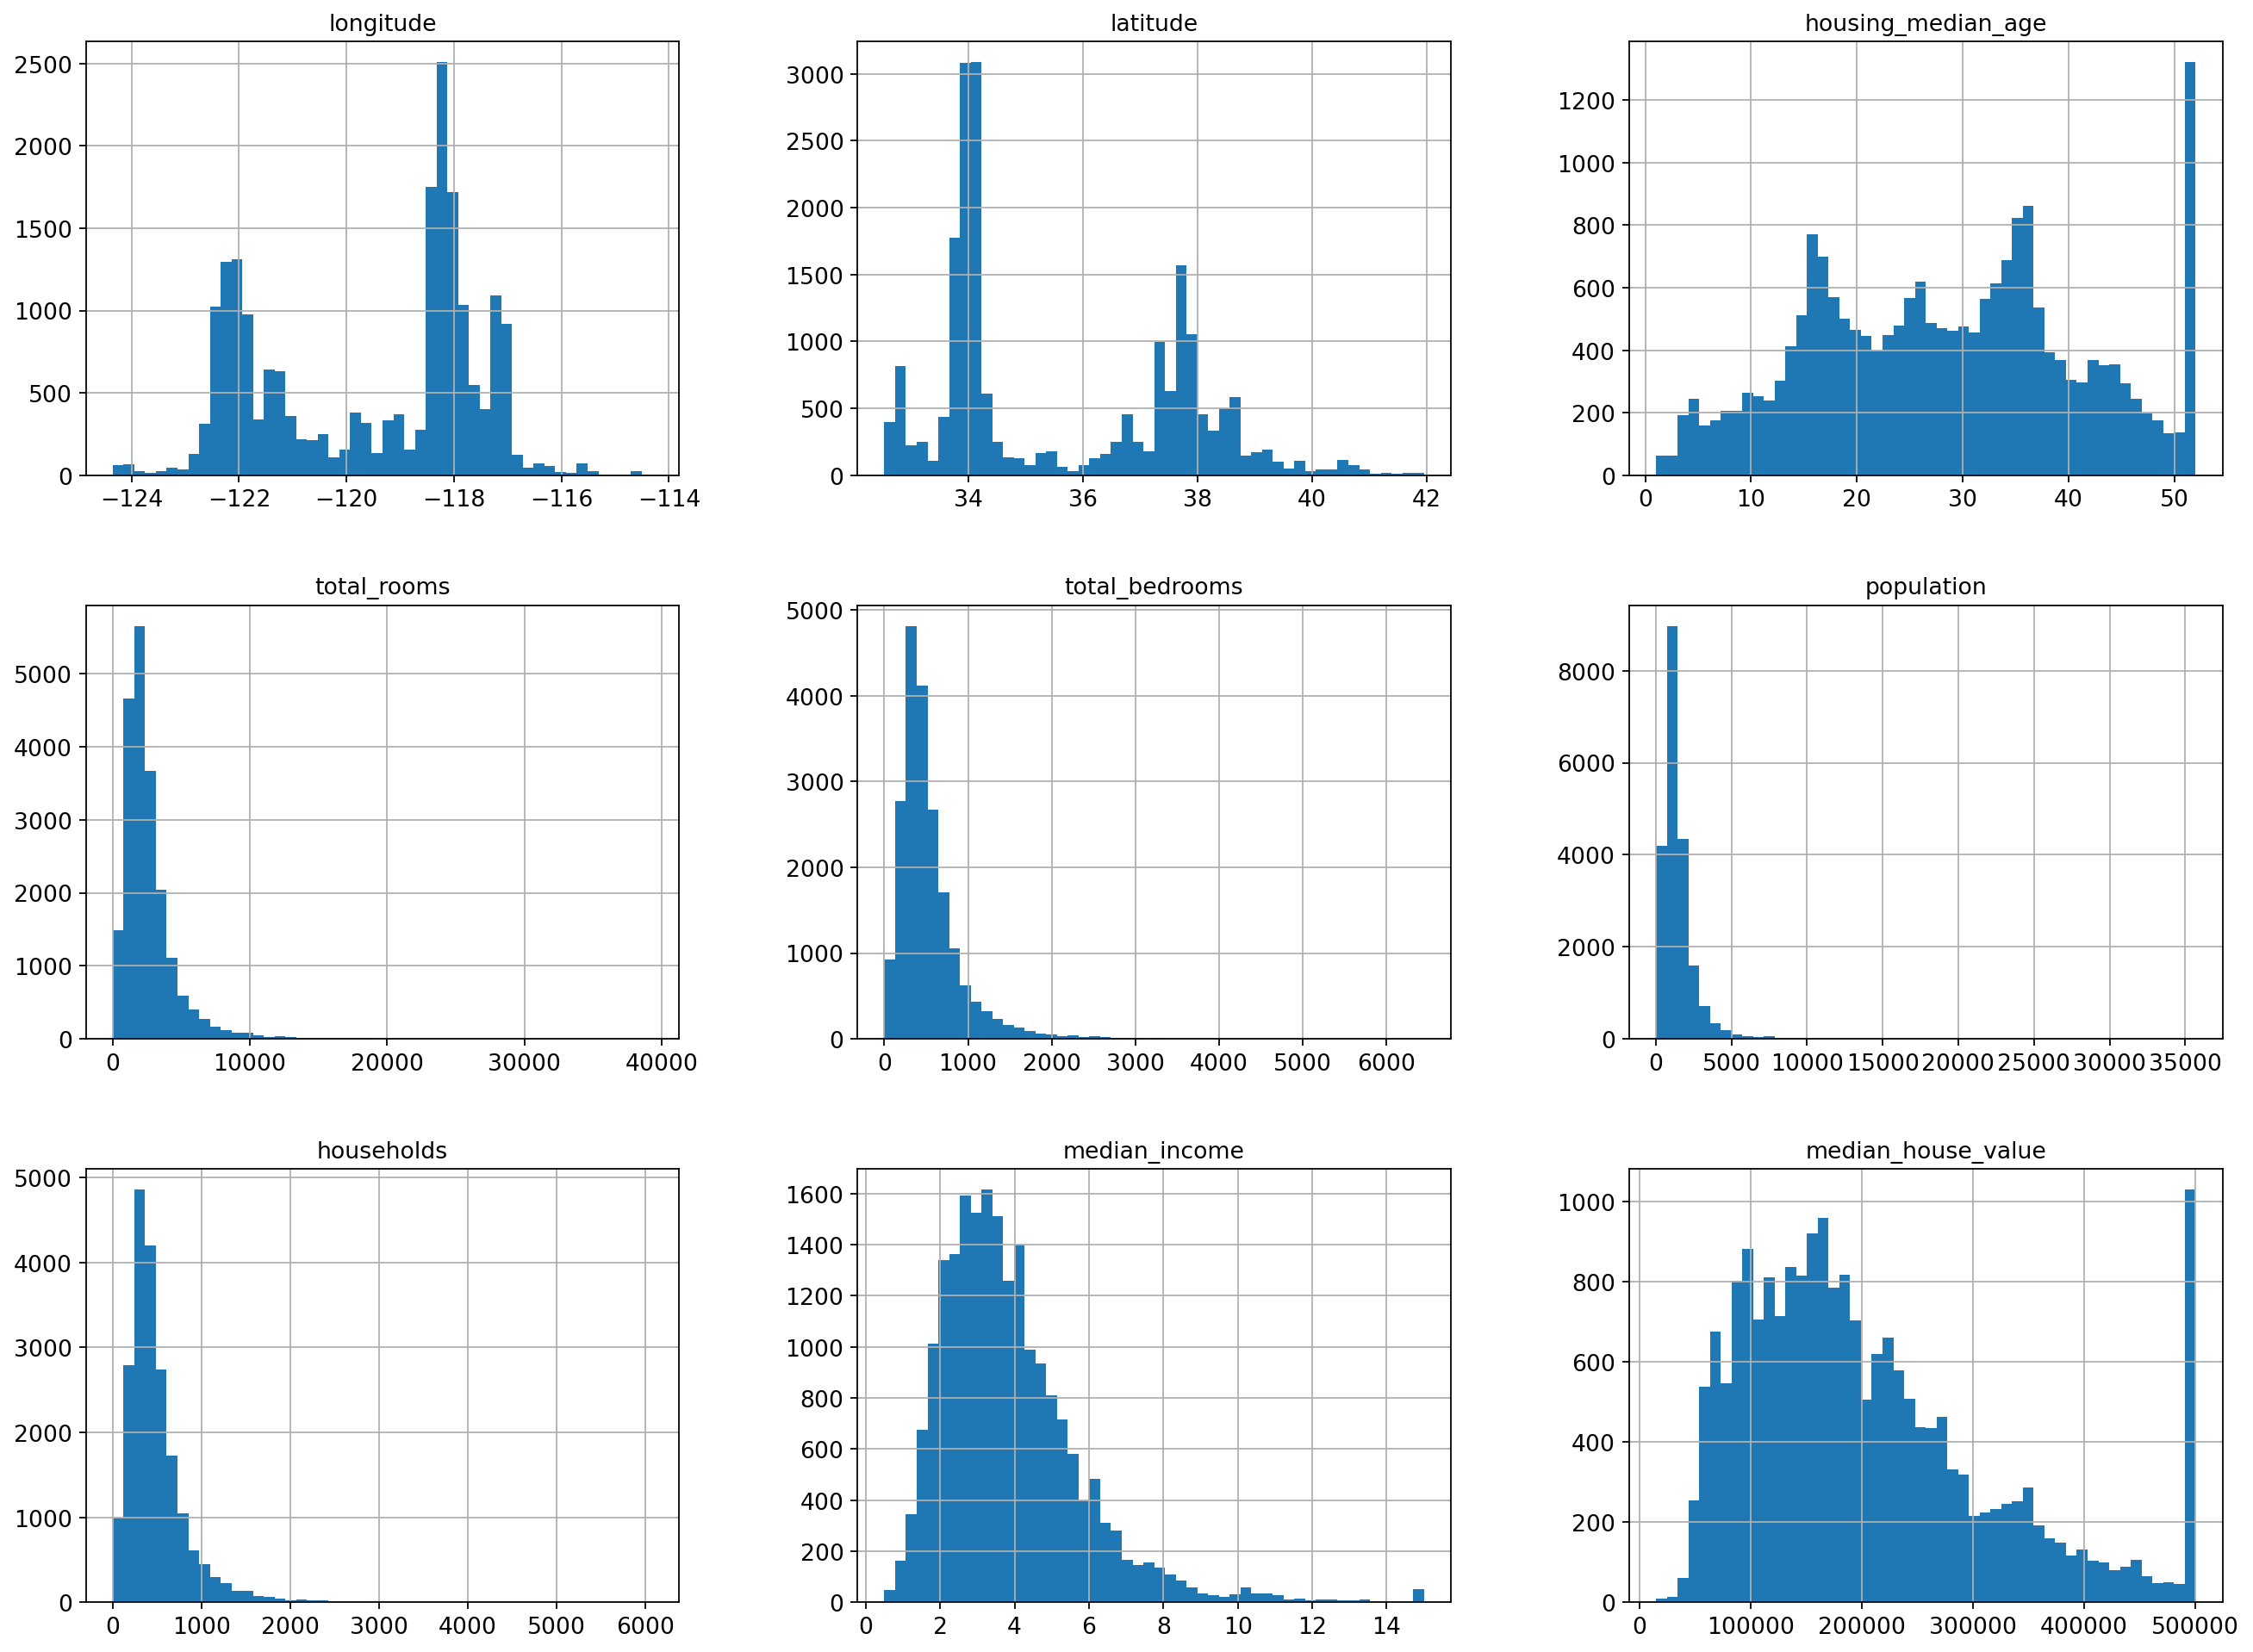

In [9]:
# Plot distributions of numeric features to understand their variability (many features are tail-heavy)
housing_data.hist(bins=50)
plt.show()

### Test-Set isolation with stratified sampling
Suppose we want to create a test set which is representative of the variation we observe in the median income feature, we cannot randomly choose 20% of instances since this will not work. The idea is to have a good number of strata with a balanced amount of instances per stratum, so that the distribution is not biased by unbalances.

In [10]:
# Initially divide income instances by a value higher or lower than 5 (create new categorical column)
housing_data['income_cat'] = np.ceil(housing_data['median_income'] / 1.5)
housing_data['income_cat'].where(housing_data['income_cat'] < 5, 5.0, inplace=True)

In [11]:
# Now we can stratify sample based on the newly formed categories
from sklearn.model_selection import StratifiedShuffleSplit # Import class

splitting = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # 20%

for train_index, test_index in splitting.split(housing_data, housing_data['income_cat']): # Watch for order in which indices are returned, first train then test
    train_set = housing_data.loc[train_index]
    test_set = housing_data.loc[test_index]

In [12]:
# Check for category frequencies matching between test set and overall dataset
housing_data['income_cat'].value_counts() / len(housing_data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [13]:
test_set['income_cat'].value_counts() / len(test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64

In [14]:
# Drop the income_cat column to restore original df shape for train and test
for sets in (train_set, test_set):
    sets.drop(['income_cat'], axis=1, inplace=True)

### Data Exploration steps
Once we have generated a train and test set, we can start exploring data and look at feature relationships.

In [15]:
data = train_set.copy()

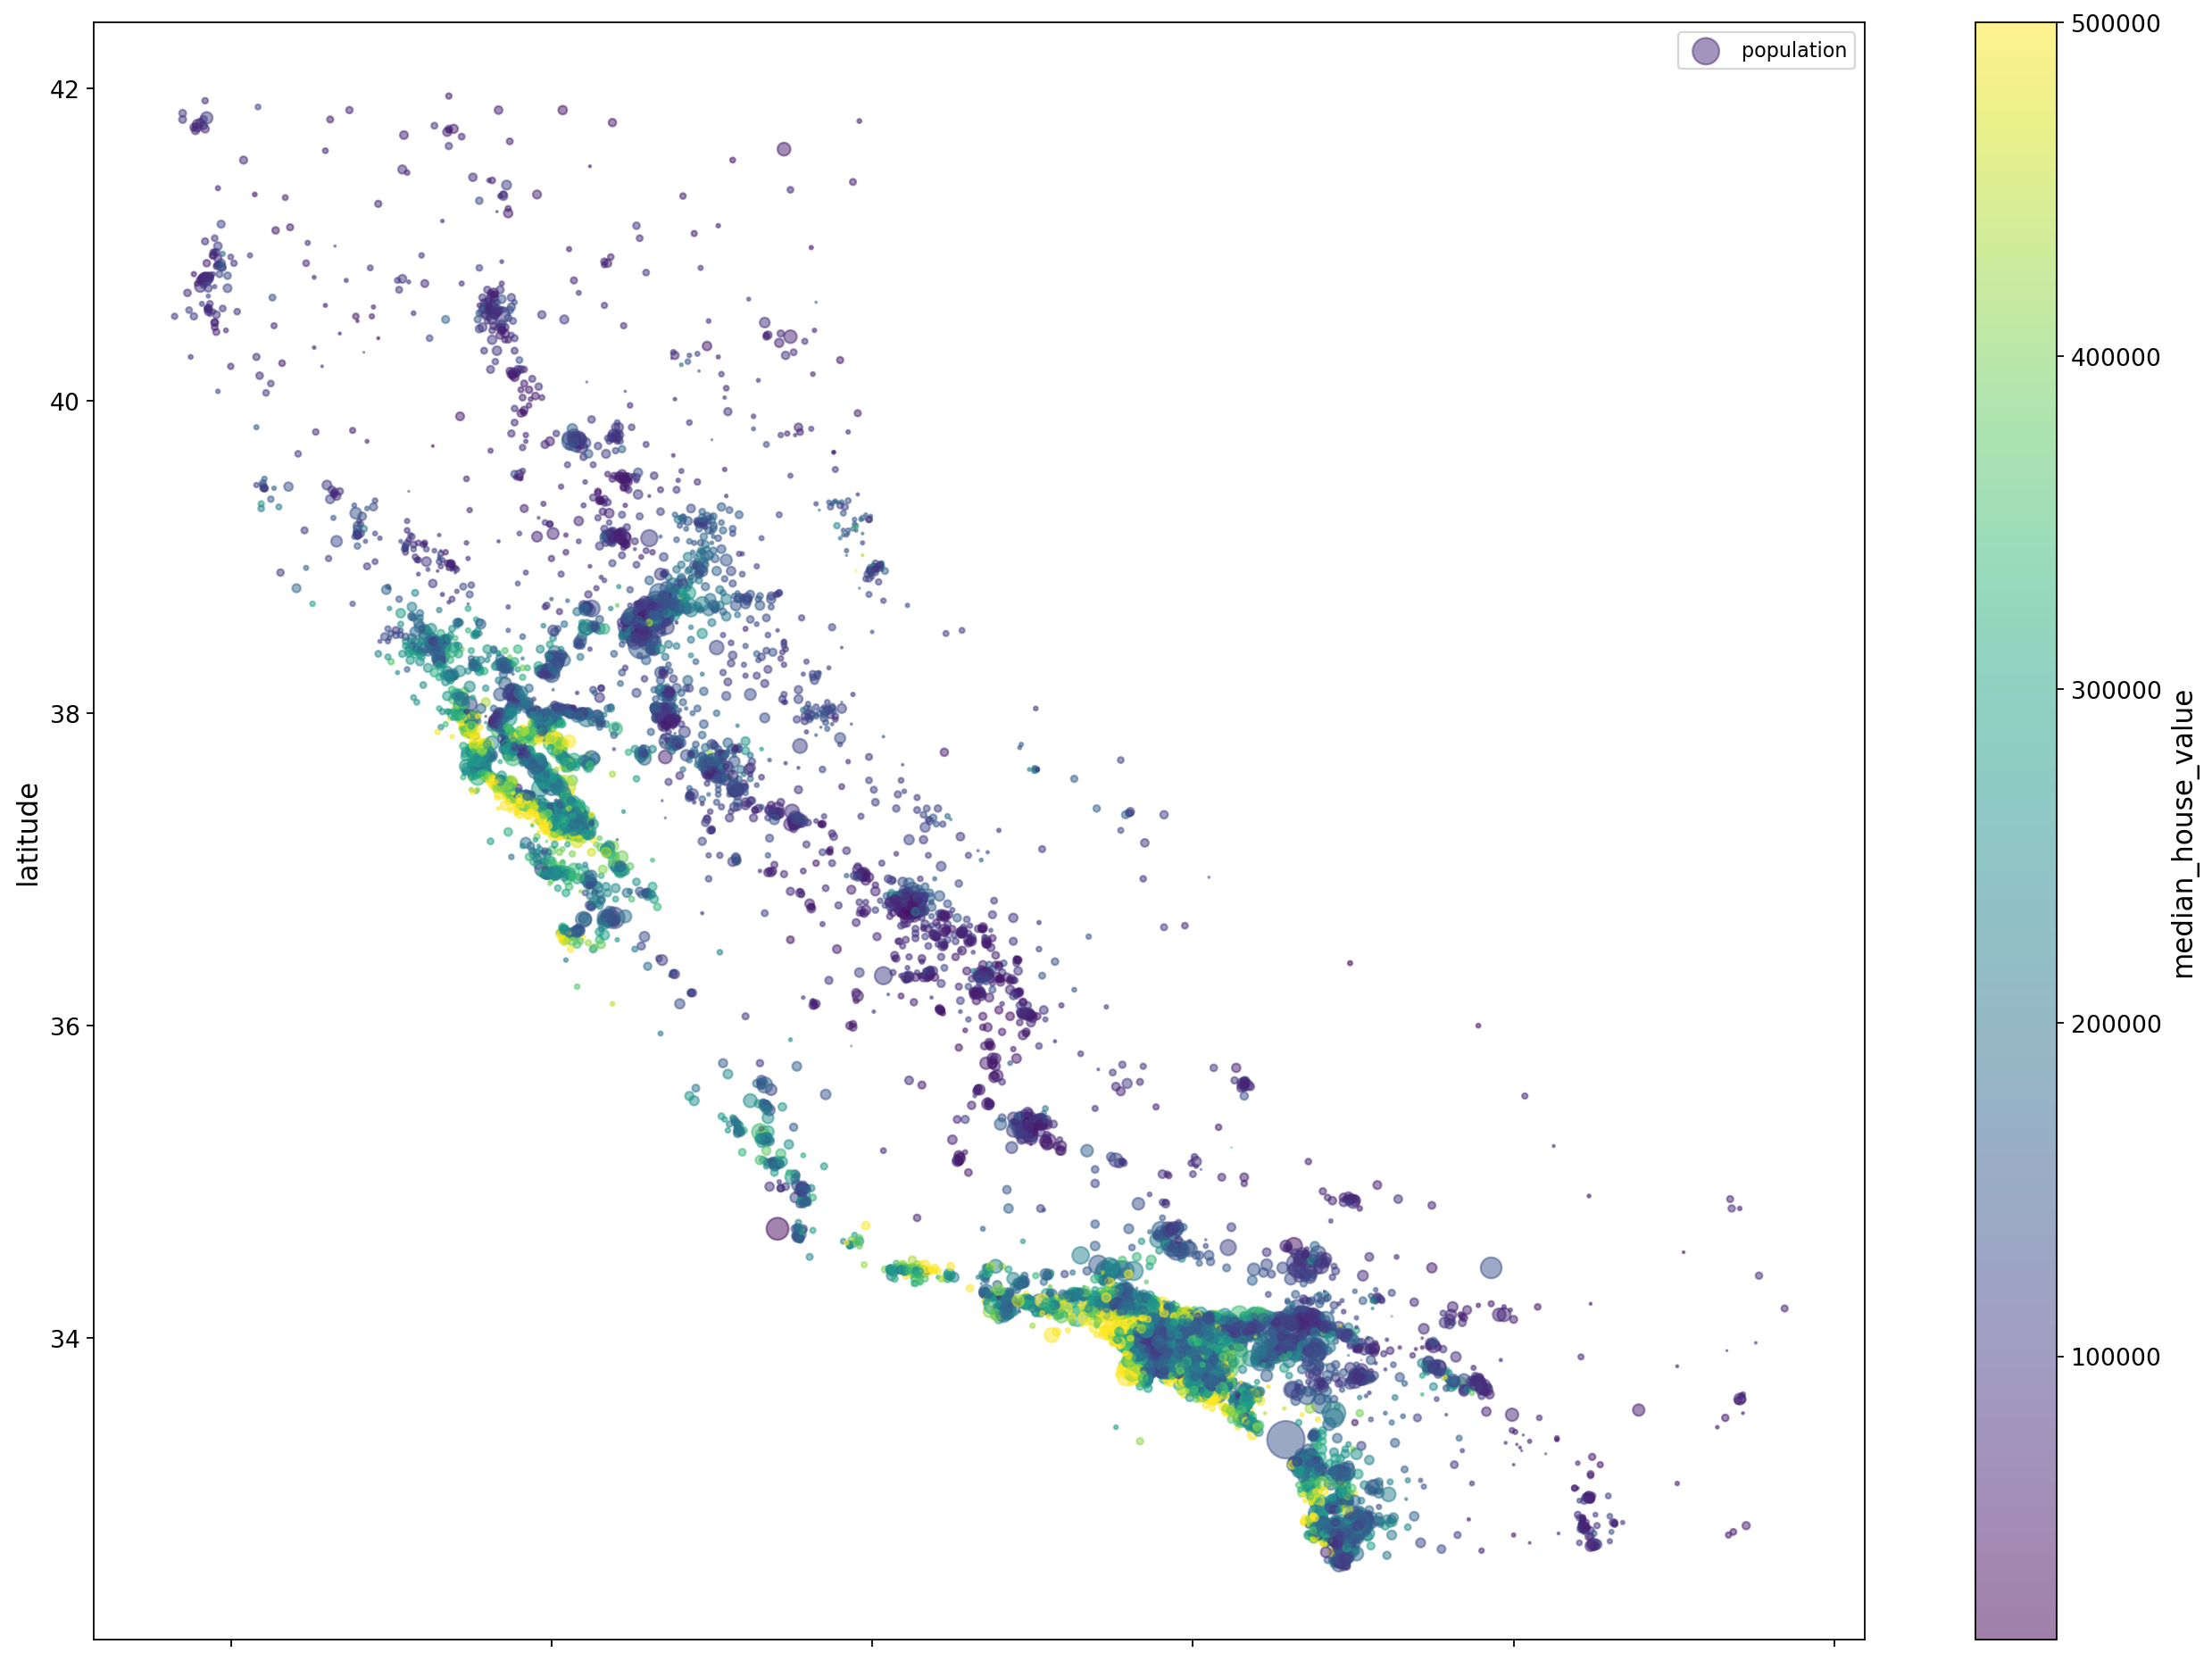

In [16]:
# Plot data geographically
data.plot(kind='scatter', y='latitude' , x='longitude', alpha=0.5, s=data['population']/100, label='population', c="median_house_value", cmap=plt.get_cmap(), colorbar=True,)
plt.legend()

In [17]:
# Explore variable relationships such as correlation
corr_mat = data.corr()

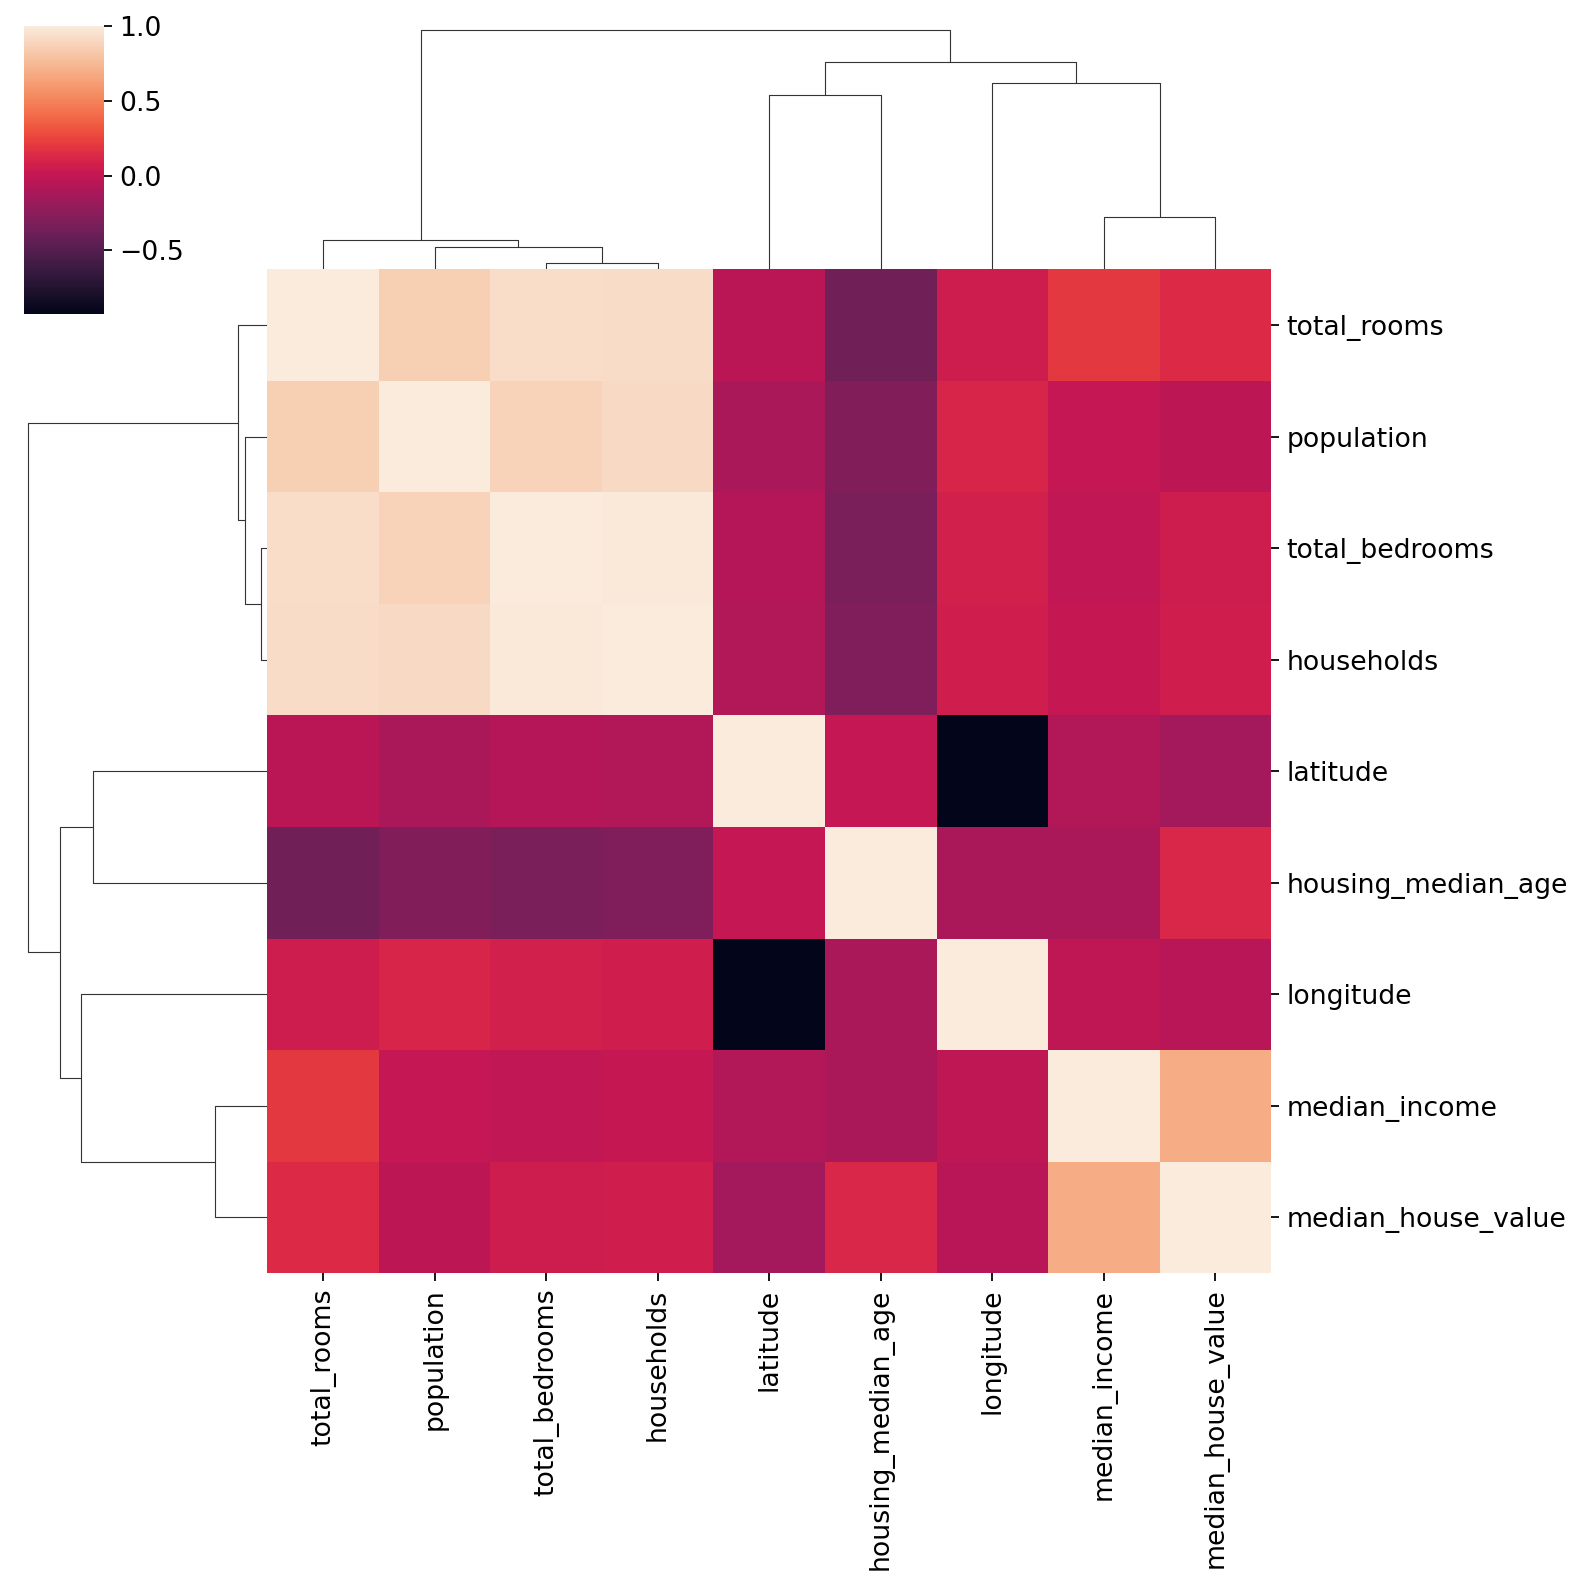

In [18]:
sns.clustermap(corr_mat)

In [19]:
# What correlates best with house value? (i.e. what are the best predictors)
corr_mat.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [20]:
# Some feature engineering
data['rooms_per_household'] = data.total_rooms / data.households
data['bedrooms_rooms_ratio'] = data.total_bedrooms / data.total_rooms
data['bedrooms_per_household'] = data.total_bedrooms / data.households

In [21]:
corr_mat = data.corr()
corr_mat.median_house_value.sort_values(ascending=False)

median_house_value        1.000000
median_income             0.687151
rooms_per_household       0.146255
total_rooms               0.135140
housing_median_age        0.114146
households                0.064590
total_bedrooms            0.047781
population               -0.026882
bedrooms_per_household   -0.043349
longitude                -0.047466
latitude                 -0.142673
bedrooms_rooms_ratio     -0.259952
Name: median_house_value, dtype: float64

### Data Preparation and Cleaning
Now it's time to take into account distribution differences among features and eventual transformations.

Pipeline structure:
- Separately approach numerical and categorical values
- For numerical: impute and scale
- For categorical: encode

In [39]:
# Define Workflow
def transform_and_scale(data):
    
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.preprocessing import StandardScaler
    
    # separate labels
    labels = data['median_house_value'].copy()
    labels = labels.values
    housing = data.drop('median_house_value', axis=1)

    # Imputation
    median = housing['total_bedrooms'].median()
    housing['total_bedrooms'] = housing['total_bedrooms'].fillna(median)

    # Add features
    housing['rooms_per_household'] = housing.total_rooms / housing.households
    housing['bedrooms_rooms_ratio'] = housing.total_bedrooms / housing.total_rooms

    # Extract all numerical variables for scaling and textual ones for encoding
    nums = housing.select_dtypes(include=np.number)
    cats = housing.loc[:,~housing.columns.isin(nums.columns)]
    
    # Encoding
    cat_enc = LabelBinarizer().fit_transform(cats)
    
    # Scaling
    scaled_nums = StandardScaler().fit_transform(nums)
    
    # Aggregate data
    prepped_data = np.c_[scaled_nums, cat_enc]
    
    return(prepped_data, labels)

In [40]:
# Apply preprocessing pipeline on training data
t_data, t_labels = transform_and_scale(train_set)

In [41]:
t_data.shape

(16512, 15)

In [46]:
t_labels.shape

(16512,)

In [49]:
t_labels.dtype

dtype('float64')

### Algorithm application
In this case, we want to use regression for prediction. There's different ways to go about it, with a simple linear regression, with a more complex decision tree, or with ensemble methods like a random forest.

In any case, the main steps for each model will be:
- Training
- Coarse evaluation (RMSE, _k_-fold cross validation)
- Fine hyperparameter tuning (Grid searches)

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# Train using k-fold cross-validation
model = DecisionTreeRegressor()
    
# Train
model.fit(t_data, t_labels)

print(model)
    
# Scores
scores = cross_val_score(model, t_data, t_labels, scoring="neg_mean_squared_error", cv=5)
    
scores = np.sqrt(scores)
    
print(f'Scores:{scores}')
print(f'Mean:{np.mean(scores)}')
print(f'Standard deviation:{np.std(scores)}')

DecisionTreeRegressor()
Scores:[nan nan nan nan nan]
Mean:nan
Standard deviation:nan


/tmp/ipykernel_2737224/1965946591.py:15: RuntimeWarning: invalid value encountered in sqrt
  scores = np.sqrt(scores)


In [50]:
test_data, test_labels = transform_and_scale(test_set)
preds = model.predict(test_data)

In [51]:
preds

array([500001., 158900., 338100., ..., 458600., 215200., 224900.])

In [55]:
pd.DataFrame({'test':test_labels.tolist(), 'prediction':preds.tolist()}).corr()

,test,prediction
test,1.000000,0.790776
prediction,0.790776,1.000000
